<a href="https://colab.research.google.com/github/lorenzrossi/InfoRet_SemanticSimilarity/blob/main/InfoRet_Semantic_Similarity_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.metrics import classification_report, confusion_matrix

!pip install opendatasets
import opendatasets as op

import os

# NLTK
import nltk as nlp
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import ngrams

# PYTORCH
!pip install transformers~=2.11.0
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
import random
import gc

from google.colab import drive
drive.mount('/content/drive')

dir = '/content/drive/MyDrive/Stanford_NLP/'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 674 kB 5.0 MB/s 
     |████████████████████████████████| 880 kB 92.7 MB/s 
     |████████████████████████████████| 1.3 MB 74.7 MB/s 
     |████████████████████████████████| 7.5 MB 92.7 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=a658fd4efd629b28b7a848f66da9571f3aa654389a6c5c30b8d95f25da71ce5a
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses
Mounted at /content/drive


In [3]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2022-12-11 15:38:09--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-11 15:38:11--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove.6B.zip.1      100%[===================>] 822.24M  3.16MB/s    in 3m 38s  

2022-12-11 15:41:49 (3.77 MB/s) - ‘glove.6B.zip.1’ saved [862182613/862182613]

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: glo

100%|██████████| 44.4M/44.4M [00:00<00:00, 163MB/s]


In [ ]:
!unzip glove.6B.zip

In [ ]:
op.download("https://www.kaggle.com/datasets/stanfordu/stanford-natural-language-inference-corpus")

In [4]:
nlp.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
datasetFolder = "stanford-natural-language-inference-corpus"

In [7]:
train_raw = pd.read_csv(os.path.join(datasetFolder, "snli_1.0_train.csv"))
test_raw = pd.read_csv(os.path.join(datasetFolder, "snli_1.0_test.csv"))
eval_raw = pd.read_csv(os.path.join(datasetFolder, "snli_1.0_dev.csv"))

In [8]:
train_raw.head(3)

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
0,neutral,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( is ( ( training ( his horse...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,3416050480.jpg#4,3416050480.jpg#4r1n,neutral,NaN,NaN,NaN,NaN
1,contradiction,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( ( ( is ( at ( a diner ) ) )...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",3416050480.jpg#4,3416050480.jpg#4r1c,contradiction,NaN,NaN,NaN,NaN
2,entailment,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,"( ( A person ) ( ( ( ( is outdoors ) , ) ( on ...",(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",3416050480.jpg#4,3416050480.jpg#4r1e,entailment,NaN,NaN,NaN,NaN


In [9]:
train_raw.describe()

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
count,550152,550152,550146,550152,550152,550152,550146,550152,550152,550152,39370,39395,39383,36914
unique,4,150736,479906,150736,479908,150736,480040,151196,550152,3,3,3,3,3
top,entailment,( ( ( A dog ) ( in ( a field ) ) ) . ),( ( A man ) ( ( is sleeping ) . ) ),(ROOT (NP (NP (DT A) (NN dog)) (PP (IN in) (NP...,(ROOT (S (NP (DT A) (NN man)) (VP (VBZ is) (VP...,A dog in a field.,A man is sleeping.,171211612.jpg#4,3416050480.jpg#4r1n,neutral,contradiction,contradiction,contradiction,entailment
freq,183416,33,335,33,335,33,335,15,1,183384,13478,13728,13701,12768


In [10]:
eval_raw.describe()

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
count,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,9986
unique,4,3319,9818,3319,9818,3319,9819,3319,10000,3,3,3,3,3
top,entailment,( ( Two ( indian men ) ) ( ( are ( ( dancing (...,( There ( ( are ( ( multiple people ) present ...,(ROOT (S (NP (CD Two) (JJ indian) (NNS men)) (...,(ROOT (S (NP (EX There)) (VP (VBP are) (ADJP (...,Two indian men are dancing in suits with an in...,There are multiple people present.,3037283097.jpg#1,4705552913.jpg#2r1n,entailment,entailment,entailment,entailment,entailment
freq,3329,6,6,6,6,6,6,6,1,3334,3396,3390,3429,3429


In [11]:
test_raw.describe()

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
count,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,9990
unique,4,3323,9810,3323,9810,3323,9810,3323,10000,3,3,3,3,3
top,entailment,( ( ( A man ) ( wearing ( a jacket ) ) ) ( ( i...,( There ( ( are ( ( multiple people ) present ...,(ROOT (S (NP (NP (DT A) (NN man)) (VP (VBG wea...,(ROOT (S (NP (EX There)) (VP (VBP are) (ADJP (...,A man wearing a jacket is listening to headpho...,There are multiple people present.,4479587916.jpg#1,2677109430.jpg#1r1n,neutral,entailment,entailment,entailment,entailment
freq,3368,6,7,6,7,6,7,6,1,3334,3400,3439,3549,3543


In [12]:
# Data shape and missing values
print('■ Train set: ' + str(train_raw.shape))
print(train_raw.isnull().sum())

print('\n■ Evaluation set: ' + str(eval_raw.shape))
print(eval_raw.isnull().sum())

print('\n■ Test set:' + str(test_raw.shape))
print(test_raw.isnull().sum())

■ Train set: (550152, 14)
gold_label                     0
sentence1_binary_parse         0
sentence2_binary_parse         6
sentence1_parse                0
sentence2_parse                0
sentence1                      0
sentence2                      6
captionID                      0
pairID                         0
label1                         0
label2                    510782
label3                    510757
label4                    510769
label5                    513238
dtype: int64

■ Evaluation set: (10000, 14)
gold_label                 0
sentence1_binary_parse     0
sentence2_binary_parse     0
sentence1_parse            0
sentence2_parse            0
sentence1                  0
sentence2                  0
captionID                  0
pairID                     0
label1                     0
label2                     0
label3                     0
label4                     0
label5                    14
dtype: int64

■ Test set:(10000, 14)
gold_label               

In [13]:
# Make sure all datasets have the same labels
print(train_raw['gold_label'].unique())
print(eval_raw['gold_label'].unique())
print(test_raw['gold_label'].unique())

['neutral' 'contradiction' 'entailment' '-']
['neutral' 'entailment' 'contradiction' '-']
['neutral' 'entailment' 'contradiction' '-']


In [14]:
# Propotion of gold labels (train only)
ratio_gold = train_raw['gold_label'].value_counts(normalize=True).sort_index(ascending=False).reset_index().set_index('index')
ratio_gold['gold_label'] = ratio_gold['gold_label'].apply(lambda x: round(x, 3))
ratio_gold

,gold_label
index,
neutral,0.332
entailment,0.333
contradiction,0.333
-,0.001


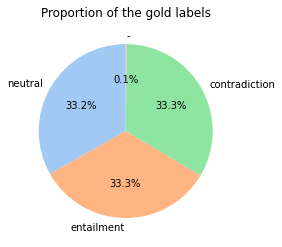

In [15]:
# Visualize the propotion
colors = sns.color_palette('pastel')
plt.pie(ratio_gold['gold_label'], labels=ratio_gold.index, colors=colors, autopct='%.1f%%', startangle=90)
plt.title('Proportion of the gold labels')
plt.show()

In [16]:
# Lengths of sentenses (train only)
# Sentense 1
train_sent1 = train_raw['sentence1'].str.count(' ') + 1
train_sent1 = train_sent1.apply(lambda x: int(x))
print('Sentence 1\n', round(train_sent1.describe(), 2))

# Sentense 2
train_sent2 = train_raw['sentence2'].dropna().str.count(' ') + 1
train_sent2 = train_sent2.apply(lambda x: int(x))
print('\nSentence 2\n', round(train_sent2.describe(), 2))

Sentence 1
 count    550152.00
mean         12.85
std           5.66
min           2.00
25%           9.00
50%          12.00
75%          16.00
max          78.00
Name: sentence1, dtype: float64

Sentence 2
 count    550146.00
mean          7.42
std           3.07
min           1.00
25%           5.00
50%           7.00
75%           9.00
max          58.00
Name: sentence2, dtype: float64


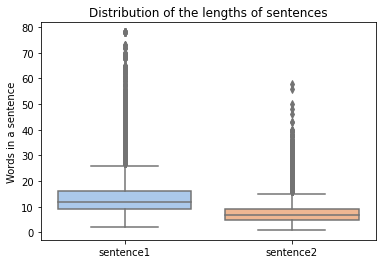

In [17]:
# Visualize the distribution of the lengths of sentences 1 and 2
train_sentences = pd.DataFrame({'sentence1':train_sent1,
                                'sentence2':train_sent2})

box = sns.boxplot(data=train_sentences, palette=colors)
box.set_ylabel('Words in a sentence')
box.set_title('Distribution of the lengths of sentences')
plt.show()

In [18]:
# Examples in sentence 1
# Minimum count of words
example1_min = train_sent1[train_sent1 == train_sent1.min()].sample(1)
print('Min word count: ', train_sent1.min())
print('Example: ', train_raw['sentence1'].loc[example1_min.index])
print('\n')

# Maximum count of words
example1_max = train_sent1[train_sent1 == train_sent1.max()].sample(1)
print('Max word count: ', train_sent1.max())
print('Example: ', train_raw['sentence1'].loc[example1_max.index])

Min word count:  2
Example:  151241    People walking
Name: sentence1, dtype: object


Max word count:  78
Example:  37567    A man wearing a helmet, red pants with white s...
Name: sentence1, dtype: object


In [19]:
# Examples in sentence 2
# Minimum count of words
example2_min = train_sent2[train_sent2 == train_sent2.min()].sample(1)
print('Min word count: ', train_sent2.min())
print('Example: ', train_raw['sentence2'].loc[example2_min.index])
print('\n')

# Maximum count of words
example2_max = train_sent2[train_sent2 == train_sent2.max()].sample(1)
print('Max word count: ', train_sent2.max())
print('Example: ', train_raw['sentence2'].loc[example2_max.index])

Min word count:  1
Example:  455456    na
Name: sentence2, dtype: object


Max word count:  58
Example:  467829    The cat toys with the catastrophically injured...
Name: sentence2, dtype: object


# PREPROCESSING

In [20]:
# Omit rows having the gold label "-" and irrelevant columns 
train = train_raw[['gold_label', 'sentence1', 'sentence2']][train_raw['gold_label'] != '-'].set_index(train_raw['pairID'][train_raw['gold_label'] != '-'])
eval = eval_raw[['gold_label', 'sentence1', 'sentence2']][eval_raw['gold_label'] != '-'].set_index(eval_raw['pairID'][eval_raw['gold_label'] != '-'])
test = test_raw[['gold_label', 'sentence1', 'sentence2']][test_raw['gold_label'] != '-'].set_index(test_raw['pairID'][test_raw['gold_label'] != '-'])

# Minimize the datasets for quick trials
train = train.iloc[:50000, :]
eval = eval.sample(100)
test = test.sample(100)

train.head(3)

,gold_label,sentence1,sentence2
pairID,,,
3416050480.jpg#4r1n,neutral,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.
3416050480.jpg#4r1c,contradiction,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette."
3416050480.jpg#4r1e,entailment,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse."


In [21]:
# Omit null indexes
train.dropna(subset=['sentence2'], inplace=True)

# Recheck the number of null values
print(train.isnull().sum())
print(eval.isnull().sum())
print(test.isnull().sum())

gold_label    0
sentence1     0
sentence2     0
dtype: int64
gold_label    0
sentence1     0
sentence2     0
dtype: int64
gold_label    0
sentence1     0
sentence2     0
dtype: int64


In [22]:
# Check sentences including URL
print(train['sentence1'][train['sentence1'].str.contains('http')].count())
print(train['sentence2'][train['sentence2'].str.contains('http')].count())

print(eval['sentence1'][eval['sentence1'].str.contains('http')].count())
print(eval['sentence2'][eval['sentence2'].str.contains('http')].count())

print(test['sentence1'][test['sentence1'].str.contains('http')].count())
print(test['sentence2'][test['sentence2'].str.contains('http')].count())

0
0
0
0
0
0


In [23]:
# Check URL-only sentences
dropindex = train.index[train['sentence2'].str.contains('http')]
train[train['sentence2'].str.contains('http')]

,gold_label,sentence1,sentence2
pairID,,,


In [24]:
# Omit URL-only sentences
train.drop(index=dropindex, inplace=True)
print(train[train['sentence2'].str.contains('http')].count())

gold_label    0
sentence1     0
sentence2     0
dtype: int64


In [25]:
# Dummy coding for gold labels
train['gold_label'] = train['gold_label'].replace('neutral', 0).replace('entailment', 1).replace('contradiction', 2)
eval['gold_label'] = eval['gold_label'].replace('neutral', 0).replace('entailment', 1).replace('contradiction', 2)
test['gold_label'] = test['gold_label'].replace('neutral', 0).replace('entailment', 1).replace('contradiction', 2)

train.head(3)

,gold_label,sentence1,sentence2
pairID,,,
3416050480.jpg#4r1n,0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.
3416050480.jpg#4r1c,2,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette."
3416050480.jpg#4r1e,1,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse."


# Frequency analysis

In [26]:
nlp.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [27]:
def tokenize(sentence):
    # Tokenization
    new_tokens = word_tokenize(sentence)
    new_tokens = [t.lower() for t in new_tokens]
    new_tokens = [t for t in new_tokens if t not in stopwords.words('english')]
    new_tokens = [t for t in new_tokens if t.isalpha()]

    # Lemmatization (become, becomes, becoming, became --> become)
    lemmatizer = WordNetLemmatizer()
    new_tokens =[lemmatizer.lemmatize(t) for t in new_tokens]
    return new_tokens

In [28]:
# Connect all sentences in the preprocessed training set
train_sentence1 = " ".join(train['sentence1'])
token_s1 = tokenize(train_sentence1)

train_sentence2 = " ".join(train['sentence2'])
token_s2 = tokenize(train_sentence2)

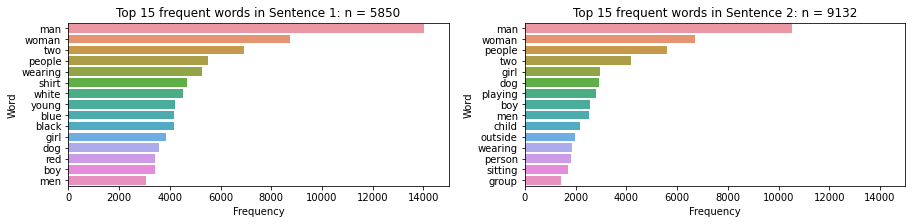

In [29]:
# Visualization of frequent words in the train dataset
# Count the words
count_s1 = Counter(token_s1)
word_freq_s1 = pd.DataFrame(count_s1.items(), columns=['Word','Frequency']).sort_values(by='Frequency', ascending=False)

count_s2 = Counter(token_s2)
word_freq_s2 = pd.DataFrame(count_s2.items(), columns=['Word','Frequency']).sort_values(by='Frequency', ascending=False)

# Create subplots
nb_ranking = 15
fig = plt.figure(figsize=(15, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

sns.barplot(x='Frequency', y='Word', data=word_freq_s1.head(nb_ranking), ax=ax1).set(xlim=(0, 15000))
ax1.set_title('Top ' + str(nb_ranking) + ' frequent words in Sentence 1: n = ' + str(len(word_freq_s1)))

sns.barplot(x='Frequency', y='Word', data=word_freq_s2.head(nb_ranking), ax=ax2).set(xlim=(0, 15000))
ax2.set_title('Top ' + str(nb_ranking) + ' frequent words in Sentence 2: n = ' + str(len(word_freq_s2)))

plt.show()

# BERT

# Tokenization

In [50]:
# Tokenization using BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Get maximum number of words
max_len = []
train_s1 = train['sentence1'].values
train_s2 = train['sentence2'].values
eval_s1 = eval['sentence1'].values
eval_s2 = eval['sentence2'].values
test_s1 = test['sentence1'].values
test_s2 = test['sentence2'].values

for sent1, sent2, sent3, sent4, sent5, sent6 in zip(train_s1, train_s2, eval_s1, eval_s2, test_s1, test_s2):
    token_words_1 = tokenizer.tokenize(sent1)
    token_words_2 = tokenizer.tokenize(sent2)
    token_words_3 = tokenizer.tokenize(sent3)
    token_words_4 = tokenizer.tokenize(sent4)
    token_words_5 = tokenizer.tokenize(sent5)
    token_words_6 = tokenizer.tokenize(sent6)

    token_words_1.extend(token_words_2)
    token_words_1.extend(token_words_3)
    token_words_1.extend(token_words_4)
    token_words_1.extend(token_words_5)
    token_words_1.extend(token_words_6)

    max_len.append(len(token_words_1))
    
max_length = max(max_len) + 3 # max length = Word tokens + 3 special tokens(1 [CLS] and 2 [SEP])

print('Max words: ', max_length)

Max words:  124


# Word embedding

In [51]:
# Function to get word ID and attention mask
def prep(sent1, sent2, label):
  input_ids = []
  attention_masks = []
  sentence_ids = []
  end_term = "[SEP]"
  labels = label.values

  for x , y in zip(sent1, sent2):
    sent= x + end_term + y
    
    encoded_dict = tokenizer.encode_plus(
        sent,
        add_special_tokens = True, # Distinguish two sentences
        max_length = max_length, # Padding
        pad_to_max_length = True, # Padding
        return_attention_mask = True, # Make attention mask
        return_tensors = 'pt', # Return Pytorch tensors
        )
    
    # Get word ID
    input_ids.append(encoded_dict['input_ids'])
    
    # Get attention mask
    attention_masks.append(encoded_dict['attention_mask'])

    # Get token type ID (distinguish sentence 1 and 2)
    sentence_ids.append(encoded_dict['token_type_ids'])
    
  # Concatenate listed tensor for vertical dimmention (dim=0)
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
    
  # Cast label list to tenosor
  labels = torch.tensor(labels)

  return input_ids, attention_masks, sentence_ids, labels

In [52]:
# Get word ID and attention mask
# train
train_ids, train_masks, sentence_ids, train_labels = prep(train_s1, train_s2, train['gold_label'])

# evaluation
eval_ids, eval_masks, sentence_ids, eval_labels = prep(eval_s1, eval_s2, eval['gold_label'])

# test
test_ids, test_masks, sentence_ids, test_labels = prep(test_s1, test_s2, test['gold_label'])

In [53]:
# Sample tensor
print('Original sentence1: ', train_s1[0])
print('Original sentence2: ', train_s2[0])
print('Token IDs:', train_ids[0]) 
print('Attention mask:', train_masks[0])

Original sentence1:  A person on a horse jumps over a broken down airplane.
Original sentence2:  A person is training his horse for a competition.
Token IDs: tensor([  101,   138,  1825,  1113,   170,  3241, 15457,  1166,   170,  3088,
         1205, 15478,   119,   102,   138,  1825,  1110,  2013,  1117,  3241,
         1111,   170,  2208,   119,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0

# Training and evaluation

In [35]:
# Make tensor dataset
train_tensor = TensorDataset(train_ids, train_masks, train_labels)
eval_tensor = TensorDataset(eval_ids, eval_masks, eval_labels)
test_tensor = TensorDataset(test_ids, test_masks, test_labels)

# Data loader
batch_size = 16
lr = 3e-5

# Train data loader
train_dataloader = DataLoader(
            train_tensor,  
            sampler = RandomSampler(train_tensor), # make batches randomly
            batch_size = batch_size
        )

# Evaluation data loader
validation_dataloader = DataLoader(
            eval_tensor, 
            sampler = SequentialSampler(eval_tensor), # make batches in order
            batch_size = batch_size 
        )

# Test data loader
test_dataloader = DataLoader(
            test_tensor, 
            sampler = SequentialSampler(test_tensor), # make batches in order
            batch_size = batch_size
        )
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Enable GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load a pre-traind BERT model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Specify a pre-trained model
    num_labels = 3,
    output_attentions = False, # Output attention vectors
    output_hidden_states = False, # Output hidden layers
).to(device)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [37]:
gc.collect()

# Train and evaluation
#lr = 5e-5 # Learning rate

#for batch in batches:
#  for rate in rates:
optimizer = AdamW(model.parameters(), lr=lr)

max_epoch = 4
train_loss_ = []
eval_loss_ = []

# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)



for epoch in range(max_epoch):
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, max_epoch))
    # Training sequence
    print('Training...')
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        # Loss means Cross Entropy Loss
        # Logits means values to be input to the softmax function
        loss, logits = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    avg_train_loss = train_loss / len(train_dataloader)  
    train_loss_.append(round(avg_train_loss, 2))
    print('Epoch training loss: ', round(avg_train_loss, 2))
    print('')

    # Evaluation sequence
    print('Evaluating...')
    model.eval()
    val_loss = 0
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad(): # don't compute grading
          (loss, logits) = model(b_input_ids, 
                                 token_type_ids = None, 
                                 attention_mask = b_input_mask,
                                 labels = b_labels)
        val_loss += loss.item()

    avg_val_loss = val_loss / len(validation_dataloader)
    eval_loss_.append(round(avg_val_loss, 2))
    print('Epoch evaluation loss: ', round(avg_val_loss, 2))
    print('')


======== Epoch 1 / 4 ========
Training...
Epoch training loss:  0.86

Evaluating...
Epoch evaluation loss:  0.64

======== Epoch 2 / 4 ========
Training...
Epoch training loss:  0.68

Evaluating...
Epoch evaluation loss:  0.6

======== Epoch 3 / 4 ========
Training...
Epoch training loss:  0.55

Evaluating...
Epoch evaluation loss:  0.54

======== Epoch 4 / 4 ========
Training...
Epoch training loss:  0.42

Evaluating...
Epoch evaluation loss:  0.69



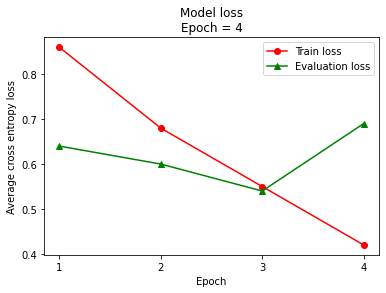

In [39]:
# Plot loss
plt.plot(list(range(1, max_epoch+1)), train_loss_, color='red', marker='o')
plt.plot(list(range(1, max_epoch+1)), eval_loss_, color='green', marker='^')
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.title('Model loss\nEpoch = ' + str(max_epoch))
plt.legend(['Train loss', 'Evaluation loss'])
plt.xlabel('Epoch')
plt.ylabel('Average cross entropy loss')
plt.show()

# Prediction and model performance checking

In [43]:
# Prediction
prediction = []
true_labels = []

# Switch the data loader (use validation or test dataloader)
dataloader_mode = validation_dataloader
#dataloader_mode = test_dataloader

model.eval() # Turn off training mode
for batch in dataloader_mode:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():   
        # Get prediction by trained model
        preds = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask)
        prediction.append(preds[0].detach().cpu().numpy())
        true_labels.append(b_labels.detach().cpu().numpy())

In [68]:
for i in range(len(prediction[0])):
  print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [66]:
# Extract relevant information from prediction
# Logits list
results = []
for i in range(len(prediction)):
  for j in range(len(prediction[0])):
    results.append(prediction[i][j])

logits_df = pd.DataFrame(results, columns=['logit_0', 'logit_1', 'logit_2'])

# Predicted label list
predicted_label = []
for i in results:
  predicted_label.append(np.argmax(i, axis=0))

pred_df = pd.DataFrame(predicted_label, columns=['pred_label'])

# True label list
true_labels2 = []
for i in range(len(true_labels)):
  for j in range(batch_size):
    true_labels2.append(true_labels[i][j])

label_df = pd.DataFrame(true_labels2, columns=['true_label'])

IndexError: ignored

In [ ]:
# Make a dataframe to calculate the performance of prediction
preds_df = pd.concat([logits_df, pred_df, label_df], axis=1)
preds_df.head()

In [ ]:
# Performance score

y_pred = preds_df.pred_label.values
y_true = preds_df.true_label.values

print(classification_report(y_true, y_pred, digits=2))

In [ ]:
# Visualize confusion matrix

cf_matrix = confusion_matrix(y_true, y_pred)
matrix = sns.heatmap(cf_matrix, annot=True)
matrix.xaxis.set_ticks_position('top') 
matrix.set(xlabel='prediction', ylabel='Gold label')
plt.title('Confusion Matrix\n0=Neutral, 1=Entailment, 2=Contradiction')
plt.show()